In [1]:
import os
from pathlib import Path
import torch
import re
import random
import transformers, datasets
from transformers import Trainer
import tqdm
from torch.utils.data import Dataset, DataLoader
import itertools
import math
import torch.nn.functional as F
import numpy as np
from torch.optim import Adam
from Bio import SeqIO
import pandas as pd

2025-03-03 11:45:17.445020: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-03 11:45:17.445076: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-03 11:45:17.446838: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-03 11:45:17.457932: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#Together, these two functions take a large fasta file and create strings of the nucleotide data contained 
#within into seperate files for each speciemen of malaria included in the file

#RUNNING THESE WILL CREATE FILES, only run if files are missing
def _helper(filename = "../data/Plasmodium_falciparum_3D7_Genome.fasta"):
    #parses file with genome into dictionary format
    record_dict = SeqIO.to_dict(SeqIO.parse(filename, "fasta"))
    for key in record_dict.keys():
        yield record_dict[key].seq, key
    return "dictionary ready"
def create_helperdata(CHUNCK_SIZE=512):
    for sequence, name in iter(_helper()):
        with open(f"../data/{name}.txt", "w") as f:
            chuncks = len(sequence) // CHUNCK_SIZE
            for i in range(chuncks):
                indx = i*CHUNCK_SIZE
                chunck = sequence[indx:indx+CHUNCK_SIZE]
                f.write(f"{chunck}\n")
    return "files created"
#_helper(filename = "../data/Plasmodium_falciparum_3D7_Genome.fasta")
#create_helperdata(CHUNCK_SIZE=512)

## 1.2 Tokenizer Training

In [3]:
#seed helps us generate the same random shuffle of data
seed = 4

#from the txt files created from the helper functions above, create pairs of adjacent nucleotides strings for one .txt file
def create_onepairs(filename):
    with open(filename) as f:
        lines = [line.rstrip('\n') for line in f]
    lines = list(zip(lines[:-1], lines[1:]))
    return lines

#repeat for each .txt file
def create_pairedData(folder_path = "../data/"):
    filenames = []
    for filename in os.listdir(folder_path):
        if '.txt' in filename:
            f = "../data/" + filename
            filenames.append(f)
    pairs = []
    for file in filenames:
        pair = create_onepairs(file)
        pairs = pairs + pair
    return pairs



In [4]:
#turns input nucleotides into appropriate integer label
class tokenizer():
    def __init__(self, vocab, special_tokens):
        #vocab is given as a list of all words 
        #but will turn into a dictionary with words as keys and integers as values

        #special_tokens are extra symbols that aren't standard words, 
        #but rather used to delimit or do something within the text

        self.vocab = special_tokens + vocab
        self.tokens = {}
        d = {}
        for i in range(len(self.vocab)):
            d[self.vocab[i]] = i
            self.tokens[i] = self.vocab[i]
        self.vocab = d

            

    def convert_ids_to_tokens(self, ids):
        #ids are a list of integers that represent the encoded words
        #this function will convert each integer into a word
        #Ex. ids = [0, 3, 4, 1] dict={0: 'word1', 1: 'word2', 2:'word3', 3:'word4', 4:'word5'}
        self.output_ids = []
        for oneid in ids:
            if oneid not in self.tokens.keys():
                self.input_ids.append(self.tokens['[UNK]'])
                continue
            self.output_ids.append(self.tokens[oneid])
        return self.output_ids

    def __call__(self, sequence):
        #sequence is a list of nucleotides
        #use tokenizer on a sequence of nucleotides to output the resulting integers that are mapped to each nucleotide
        self.input_ids = {'input_ids':[]}
        if not isinstance(sequence, list):
            sequence = [sequence]
        for nucleotide in sequence:
            if nucleotide not in self.vocab.keys():
                self.input_ids['input_ids'].append(self.vocab['[UNK]'])
                continue
            self.input_ids['input_ids'].append(self.vocab[nucleotide])
        return self.input_ids

t = tokenizer(vocab=['A', 'T', 'G', 'C'], 
          special_tokens=['[PAD]', '[CLS]', '[SEP]', '[MASK]', '[UNK]'])     

MAX_LEN = 1024

In [5]:
#THE CODE BELOW WAS TAKEN AND MODIFIED FROM USER CHEEKAN on Medium, 
#https://medium.com/data-and-beyond/complete-guide-to-building-bert-model-from-sratch-3e6562228891

# 2) Pre-processing

In [6]:
#takes in paired nucleotide data and tokenizes and tensorizes it to prepare for training or prediction. Will mask portions 
# of the nucleotide sequence when training

class BERTDataset(Dataset):
    def __init__(self, data_pair, tokenizer, seq_len=1024, is_train=False):

        self.tokenizer = tokenizer
        self.seq_len = seq_len
        self.corpus_lines = len(data_pair)
        self.lines = data_pair
        self.is_train = is_train

    def __len__(self):
        return self.corpus_lines

    def __getitem__(self, item):

        # Step 1: get random sentence pair, either negative or positive (saved as is_next_label)
        t1, t2, is_next_label = self.get_sent(item)

        # Step 2: replace random words in sentence with mask / random words\
        t1_random, t1_label = self.random_word(t1)
        t2_random, t2_label = self.random_word(t2)
            

        # Step 3: Adding CLS and SEP tokens to the start and end of sentences
        # Adding PAD token for labels
        t1 = [self.tokenizer.vocab['[CLS]']] + t1_random + [self.tokenizer.vocab['[SEP]']]
        t2 = t2_random + [self.tokenizer.vocab['[SEP]']]
        t1_label = [self.tokenizer.vocab['[PAD]']] + t1_label + [self.tokenizer.vocab['[PAD]']]
        t2_label = t2_label + [self.tokenizer.vocab['[PAD]']]

        # Step 4: combine sentence 1 and 2 as one input
        # adding PAD tokens to make the sentence same length as seq_len
        segment_label = ([1 for _ in range(len(t1))] + [2 for _ in range(len(t2))])[:self.seq_len]
        bert_input = (t1 + t2)[:self.seq_len]
        bert_label = (t1_label + t2_label)[:self.seq_len]
        padding = [self.tokenizer.vocab['[PAD]'] for _ in range(self.seq_len - len(bert_input))]
        bert_input.extend(padding), bert_label.extend(padding), segment_label.extend(padding)

        output = {"bert_input": bert_input,
                  "bert_label": bert_label,
                  "segment_label": segment_label,
                  "is_next": is_next_label}

        return {key: torch.tensor(value) for key, value in output.items()}

    def random_word(self, sentence):
        tokens = list(sentence)#sentence.split()
        output_label = []
        output = []

        # 15% of the tokens would be replaced
        for i, token in enumerate(tokens):
            prob = random.random()

            # remove cls and sep token
            #token_id = self.tokenizer(token)['input_ids'][1:-1]

            # 15% chance of altering token
            if prob < 0.15 and self.is_train:
                prob /= 0.15

                # 80% chance change token to mask token
                if prob < 0.8:
                    output.append(self.tokenizer.vocab['[MASK]'])

                # 10% chance change token to random token
                elif prob < 0.9:
                    output.append(random.randrange(len(self.tokenizer.vocab)))

                # 10% chance change token to current token
                else:
                    output.append(self.tokenizer(token)["input_ids"])

                output_label.append(self.tokenizer(token)["input_ids"])

            else:
                output.append(self.tokenizer(token)["input_ids"])
                output_label.append(self.tokenizer(token)["input_ids"])

        # flattening
        output = list(itertools.chain(*[[x] if not isinstance(x, list) else x for x in output]))
        output_label = list(itertools.chain(*[[x] if not isinstance(x, list) else x for x in output_label]))
        assert len(output) == len(output_label)
        return output, output_label

    def get_sent(self, index):
        '''return random sentence pair'''
        t1, t2 = self.get_corpus_line(index)

        # negative or positive pair, for next sentence prediction
        if random.random() > 0.5:
            return t1, t2, 1
        else:
            return t1, self.get_random_line(), 0

    def get_corpus_line(self, item):
        '''return sentence pair'''
        return self.lines[item][0], self.lines[item][1]

    def get_random_line(self):
        '''return random single sentence'''
        return self.lines[random.randrange(len(self.lines))][1]

# 3) Modeling

In [7]:
### Creates embeddings/ associates values with the value, position, and segment of each nucleotide in a sequence
#Basically gives mathematical values to where and what each nucleotide in a sequence so that they can be mathematically computed.
class PositionalEmbedding(torch.nn.Module):

    def __init__(self, d_model, max_len=1024):
        super().__init__()

        # Compute the positional encodings once in log space.
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        pe = torch.zeros(max_len, d_model).float().to(self.device)
        pe.require_grad = False

        for pos in range(max_len):
            # for each dimension of the each position
            for i in range(0, d_model, 2):
                pe[pos, i] = math.sin(pos / (10000 ** ((2 * i)/d_model)))
                pe[pos, i + 1] = math.cos(pos / (10000 ** ((2 * (i + 1))/d_model)))

        # include the batch size
        self.pe = pe.unsqueeze(0)
        # self.register_buffer('pe', pe)

    def forward(self, x):
        return self.pe

class BERTEmbedding(torch.nn.Module):
    """
    BERT Embedding which is consisted with under features
        1. TokenEmbedding : normal embedding matrix
        2. PositionalEmbedding : adding positional information using sin, cos
        2. SegmentEmbedding : adding sentence segment info, (sent_A:1, sent_B:2)
        sum of all these features are output of BERTEmbedding
    """

    def __init__(self, vocab_size, embed_size, seq_len=1024, dropout=0.1):
        """
        :param vocab_size: total vocab size
        :param embed_size: embedding size of token embedding
        :param dropout: dropout rate
        """

        super().__init__()
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.embed_size = embed_size
        # (m, seq_len) --> (m, seq_len, embed_size)
        # padding_idx is not updated during training, remains as fixed pad (0)
        self.token = torch.nn.Embedding(vocab_size, embed_size, padding_idx=0, device=self.device)
        self.segment = torch.nn.Embedding(3, embed_size, padding_idx=0, device=self.device)
        self.position = PositionalEmbedding(d_model=embed_size, max_len=seq_len)
        self.dropout = torch.nn.Dropout(p=dropout)

    def forward(self, sequence, segment_label=None, is_train=False):
        x = self.token(sequence) + self.position(sequence)
        if segment_label is not None:
            x += self.segment(segment_label)

        if is_train == False:
            return x
        return self.dropout(x)


In [8]:
### attention layers
#creates a matrix where each row represents the word being queried and the column represents the word whose relationship value
#is being calculated so that words which are highly related have a high value, and words that are not related have a low value
class MultiHeadedAttention(torch.nn.Module):

    def __init__(self, heads, d_model, dropout=0.1):
        super(MultiHeadedAttention, self).__init__()

        assert d_model % heads == 0
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.d_k = d_model // heads
        self.heads = heads
        self.dropout = torch.nn.Dropout(dropout)

        self.query = torch.nn.Linear(d_model, d_model, device=self.device)
        self.key = torch.nn.Linear(d_model, d_model, device=self.device)
        self.value = torch.nn.Linear(d_model, d_model, device=self.device)
        self.output_linear = torch.nn.Linear(d_model, d_model, device=self.device)

    def forward(self, query, key, value, mask, is_train=False):
        """
        query, key, value of shape: (batch_size, max_len, d_model)
        mask of shape: (batch_size, 1, 1, max_words)
        """
        # (batch_size, max_len, d_model)
        query = self.query(query)
        key = self.key(key)
        value = self.value(value)

        # (batch_size, max_len, d_model) --> (batch_size, max_len, h, d_k) --> (batch_size, h, max_len, d_k)
        query = query.view(query.shape[0], -1, self.heads, self.d_k).permute(0, 2, 1, 3)
        key = key.view(key.shape[0], -1, self.heads, self.d_k).permute(0, 2, 1, 3)
        value = value.view(value.shape[0], -1, self.heads, self.d_k).permute(0, 2, 1, 3)

        # (batch_size, h, max_len, d_k) matmul (batch_size, h, d_k, max_len) --> (batch_size, h, max_len, max_len)
        scores = torch.matmul(query, key.permute(0, 1, 3, 2)) / math.sqrt(query.size(-1))

        # fill 0 mask with super small number so it wont affect the softmax weight
        # (batch_size, h, max_len, max_len)
        mask = mask.float()
        mask = (1 - mask) * -1e9 
        scores = scores + mask

        # (batch_size, h, max_len, max_len)
        # softmax to put attention weight for all non-pad tokens
        # max_len X max_len matrix of attention
        weights = F.softmax(scores, dim=-1)
        if is_train == True:
            weights = self.dropout(weights) 

        # (batch_size, h, max_len, max_len) matmul (batch_size, h, max_len, d_k) --> (batch_size, h, max_len, d_k)
        context = torch.matmul(weights, value)

        # (batch_size, h, max_len, d_k) --> (batch_size, max_len, h, d_k) --> (batch_size, max_len, d_model)
        context = context.permute(0, 2, 1, 3).contiguous().view(context.shape[0], -1, self.heads * self.d_k)

        # (batch_size, max_len, d_model)
        return self.output_linear(context)

class FeedForward(torch.nn.Module):
    "Implements FFN equation"

    def __init__(self, d_model, middle_dim=2048, dropout=0.1):
        super(FeedForward, self).__init__()

        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.fc1 = torch.nn.Linear(d_model, middle_dim, device=self.device)
        self.fc2 = torch.nn.Linear(middle_dim, d_model, device=self.device)
        self.dropout = torch.nn.Dropout(dropout)
        self.activation = torch.nn.GELU()

    def forward(self, x, is_train=False):
        out = self.activation(self.fc1(x))
        if is_train == True:
            out = self.fc2(self.dropout(out))
        else:
            out = self.fc2(out)
        return out

#Uses multihead attention to calculate the relationship of each word in the input sequence with each other word
class EncoderLayer(torch.nn.Module):
    def __init__(
        self,
        d_model=768,
        heads=12,
        feed_forward_hidden=768 * 4,
        dropout=0.1
        ):
        super(EncoderLayer, self).__init__()
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.layernorm = torch.nn.LayerNorm(d_model, device = self.device)
        self.self_multihead = MultiHeadedAttention(heads, d_model)
        self.feed_forward = FeedForward(d_model, middle_dim=feed_forward_hidden)
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, embeddings, mask, is_train=False):
        # embeddings: (batch_size, max_len, d_model)
        # encoder mask: (batch_size, 1, 1, max_len)
        # result: (batch_size, max_len, d_model)
        interacted = self.dropout(self.self_multihead(embeddings, embeddings, embeddings, mask))
        # residual layer
        interacted = self.layernorm(interacted + embeddings)
        # bottleneck
        feed_forward_out = self.dropout(self.feed_forward(interacted))
        
        if is_train == True:
            interacted = self.dropout(self.self_multihead(embeddings, embeddings, embeddings, mask))
            interacted = self.layernorm(interacted + embeddings)
            feed_forward_out = self.dropout(self.feed_forward(interacted))
        else: 
            interacted = self.self_multihead(embeddings, embeddings, embeddings, mask)
            interacted = self.layernorm(interacted + embeddings)
            feed_forward_out = self.feed_forward(interacted)
    
        encoded = self.layernorm(feed_forward_out + interacted)
        
        return encoded


In [9]:
#Combines each layer above to create predictions based on the values calculated by each layer
class BERT(torch.nn.Module):
    """
    BERT model : Bidirectional Encoder Representations from Transformers.
    """

    def __init__(self, vocab_size, d_model=768, n_layers=12, heads=12, dropout=0.1):
        """
        :param vocab_size: vocab_size of total words
        :param hidden: BERT model hidden size
        :param n_layers: numbers of Transformer blocks(layers)
        :param attn_heads: number of attention heads
        :param dropout: dropout rate
        """

        super().__init__()
        self.d_model = d_model
        self.n_layers = n_layers
        self.heads = heads

        # paper noted they used 4*hidden_size for ff_network_hidden_size
        self.feed_forward_hidden = d_model * 4

        # embedding for BERT, sum of positional, segment, token embeddings
        self.embedding = BERTEmbedding(vocab_size=vocab_size, embed_size=d_model)

        # multi-layers transformer blocks, deep network
        self.encoder_blocks = torch.nn.ModuleList(
            [EncoderLayer(d_model, heads, d_model * 4, dropout) for _ in range(n_layers)])

    def forward(self, x, segment_info=None, is_train=False):
        # attention masking for padded token
        # (batch_size, 1, seq_len, seq_len)
        mask = (x > 0).unsqueeze(1).repeat(1, x.size(1), 1).unsqueeze(1)

        # embedding the indexed sequence to sequence of vectors
        x = self.embedding(x, segment_info)

        # running over multiple transformer blocks
        for encoder in self.encoder_blocks:
            x = encoder.forward(x, mask)
        return x

class NextSentencePrediction(torch.nn.Module):
    """
    2-class classification model : is_next, is_not_next
    """

    def __init__(self, hidden):
        """
        :param hidden: BERT model output size
        """
        super().__init__()
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu' 
        self.linear = torch.nn.Linear(hidden, 2, device=self.device)
        self.softmax = torch.nn.LogSoftmax(dim=-1)

    def forward(self, x, is_train=False):
        # use only the first token which is the [CLS]
        return self.softmax(self.linear(x[:, 0]))

class MaskedLanguageModel(torch.nn.Module):
    """
    predicting origin token from masked input sequence
    n-class classification problem, n-class = vocab_size
    """

    def __init__(self, hidden, vocab_size):
        """
        :param hidden: output size of BERT model
        :param vocab_size: total vocab size
        """
        super().__init__()
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu' 
        self.linear = torch.nn.Linear(hidden, vocab_size, device=self.device)
        self.softmax = torch.nn.LogSoftmax(dim=-1)

    def forward(self, x, is_train=False):
        return self.softmax(self.linear(x))

class BERTLM(torch.nn.Module):
    """
    BERT Language Model
    Next Sentence Prediction Model + Masked Language Model
    """

    def __init__(self, bert: BERT, vocab_size):
        """
        :param bert: BERT model which should be trained
        :param vocab_size: total vocab size for masked_lm
        """

        super().__init__()
        self.bert = bert
        self.next_sentence = NextSentencePrediction(self.bert.d_model)
        self.mask_lm = MaskedLanguageModel(self.bert.d_model, vocab_size)

    def forward(self, x, segment_label=None, is_train=False):
        x = self.bert(x, segment_label)
        if segment_label is not None:
            return self.next_sentence(x), self.mask_lm(x)
        else:
            return self.mask_lm(x)

# 4) Training

In [10]:
### optimizer
class ScheduledOptim():
    '''A simple wrapper class for learning rate scheduling'''

    def __init__(self, optimizer, d_model, n_warmup_steps):
        self._optimizer = optimizer
        self.n_warmup_steps = n_warmup_steps
        self.n_current_steps = 0
        self.init_lr = np.power(d_model, -0.5)

    def step_and_update_lr(self):
        "Step with the inner optimizer"
        self._update_learning_rate()
        self._optimizer.step()

    def zero_grad(self):
        "Zero out the gradients by the inner optimizer"
        self._optimizer.zero_grad()

    def _get_lr_scale(self):
        return np.min([
            np.power(self.n_current_steps, -0.5),
            np.power(self.n_warmup_steps, -1.5) * self.n_current_steps])

    def _update_learning_rate(self):
        ''' Learning rate scheduling per step '''

        self.n_current_steps += 1
        lr = self.init_lr * self._get_lr_scale()

        for param_group in self._optimizer.param_groups:
            param_group['lr'] = lr

In [11]:
### trainer
#creates models that are around 300 mb in size, so they can't be pushed to github
class BERTTrainer:
    def __init__(
        self,
        model,
        train_dataloader,
        test_dataloader=None,
        lr= 1e-4,
        weight_decay=0.01,
        betas=(0.9, 0.999),
        warmup_steps=10000,
        log_freq=10,
        device='cuda'
        ):

        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.device = device
        self.model = model
        self.train_data = train_dataloader
        self.test_data = test_dataloader

        # Setting the Adam optimizer with hyper-param
        self.optim = Adam(self.model.parameters(), lr=lr, betas=betas, weight_decay=weight_decay)
        self.optim_schedule = ScheduledOptim(
            self.optim, self.model.bert.d_model, n_warmup_steps=warmup_steps
            )

        # Using Negative Log Likelihood Loss function for predicting the masked_token
        self.criterion = torch.nn.NLLLoss(ignore_index=0)
        self.log_freq = log_freq
        print("Total Parameters:", sum([p.nelement() for p in self.model.parameters()]))

    def train(self, epoch):
        self.iteration(epoch, self.train_data)

    def test(self, epoch):
        self.iteration(epoch, self.test_data, train=False)

    def iteration(self, epoch, data_loader, train=True):

        avg_loss = 0.0
        total_correct = 0
        total_element = 0

        mode = "train" if train else "test"

        # progress bar
        data_iter = tqdm.tqdm(
            enumerate(data_loader),
            desc="EP_%s:%d" % (mode, epoch),
            total=len(data_loader),
            bar_format="{l_bar}{r_bar}"
        )

        for i, data in data_iter:

            # 0. batch_data will be sent into the device(GPU or cpu)
            data = {key: value.to(self.device) for key, value in data.items()}

            in_bert = data["bert_input"]
            segmentlabel_bert = data["segment_label"]
            is_next_bert = data["is_next"]
            label_bert = data["bert_label"]
            

            # 1. forward the next_sentence_prediction and masked_lm model
            next_sent_output, mask_lm_output = self.model.forward(in_bert, segmentlabel_bert, is_train=True)

            # 2-1. NLL(negative log likelihood) loss of is_next classification result
            next_loss = self.criterion(next_sent_output, is_next_bert)

            # 2-2. NLLLoss of predicting masked token word
            # transpose to (m, vocab_size, seq_len) vs (m, seq_len)
            # criterion(mask_lm_output.view(-1, mask_lm_output.size(-1)), data["bert_label"].view(-1))
            mask_loss = self.criterion(mask_lm_output.transpose(1, 2), label_bert)

            # 2-3. Adding next_loss and mask_loss : 3.4 Pre-training Procedure
            loss = mask_loss#next_loss + mask_loss

            # 3. backward and optimization only in train
            if train:
                self.optim_schedule.zero_grad()
                loss.backward()
                self.optim_schedule.step_and_update_lr()

            # next sentence prediction accuracy
            correct = next_sent_output.argmax(dim=-1).eq(is_next_bert).sum().item()
            avg_loss += loss.item()
            total_correct += correct
            total_element += is_next_bert.nelement()

            # step 4: validation step

            post_fix = {
                "epoch": epoch,
                "iter": i,
                "avg_loss": avg_loss / (i + 1),
                "avg_acc": total_correct / total_element * 100,
                "loss": loss.item()
            }

            if i % self.log_freq == 0:
                data_iter.write(str(post_fix))
        print(
            f"EP{epoch}, {mode}: \
            avg_loss={avg_loss / len(data_iter)}, \
            total_acc={total_correct * 100.0 / total_element}"
        )



In [ ]:
#Prepare data from FASTA file into lists of nucleotides
pairs = create_pairedData()
random.Random(seed).shuffle(pairs)

training_size = int(len(pairs)*0.8)

#Prepare data from lists of nucleotides into tensored and tokenized data ready to be batched and trained
train_data = BERTDataset(pairs[:training_size], seq_len=MAX_LEN, tokenizer=t)
train_loader = DataLoader(train_data, batch_size=4, shuffle=True, pin_memory=True)
bert_model = BERT(len(t.vocab))
bert_lm = BERTLM(bert_model, len(t.vocab))
bert_trainer = BERTTrainer(bert_lm, train_loader, device='cuda')
epochs = 20

#For every specified number of epochs, save the current version of the model as a file to the filepath
for epoch in range(epochs):
    bert_trainer.train(epoch)
    if epoch % 1 == 0 and epoch != 0:
        filename = "../model/largeMalariaModelEpoch" + str(epoch)
        torch.save(bert_trainer.model.state_dict(), filename)

In [ ]:
#Don't script anything below this

In [ ]:
#torch.save(bert_trainer.model.state_dict(), "../model/small_test_model")
#model = BERTLM(bert_model, len(t.vocab))
#model.load_state_dict(torch.load("../model/malariaModelEpoch9", weights_only=True))

In [ ]:
#val_data = BERTDataset(pairs[5:10], seq_len=MAX_LEN, tokenizer=t, is_train=False)

# calculate accuracy

In [12]:
bert_model = BERT(len(t.vocab))
model = BERTLM(bert_model, len(t.vocab))
model.load_state_dict(torch.load("../model/largeMalariaModelEpoch1", map_location=torch.device('cpu')))

<All keys matched successfully>

In [13]:
pairs = create_pairedData()
random.Random(seed).shuffle(pairs)

In [28]:
training_size = int(len(pairs)*0.8)
val_data = BERTDataset(pairs[training_size:], seq_len=MAX_LEN, tokenizer=t, is_train=False)

In [29]:
def calc_acc(val_data, model_name, tokenizer):
    #bert_model = BERT(len(t.vocab))
    #model = BERTLM(bert_model, len(t.vocab))
    #model.load_state_dict(torch.load("../model/"+model_name, map_location=torch.device('cpu')))
    sequences = []
    predictions = []
    accuracies = []
    print('loading in data')
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    ind = 0
    for data in val_data:
        if ind % 1000 == 0:
            print(ind)
        in_bert = data["bert_input"].to(device)
        #segmentlabel_bert = data["segment_label"].to(device)
        #is_next_bert = data["is_next"].to(device)
        #label_bert = data["bert_label"].to(device)
        
        #turns tensorized and tokenized input back into readable nucleotides
        seq = t.convert_ids_to_tokens(in_bert.tolist())
        sequences.append(seq)

        #turns tensorized and tokenized output back into readable nucleotides
        output = model(in_bert.reshape(1,-1))
        #return output
        #.max grabs the option with the largest weight
        tensor_pred = torch.max(output[:512], axis=-1)[1]
        pred = tensor_pred.tolist()
        pred = sum(pred, [])
        pred = t.convert_ids_to_tokens(pred)
        predictions.append(pred)
        
        num_correct = 0
        for i in range(len(seq)):
            if seq[i] == pred[i]:
                num_correct = num_correct + 1
        acc = num_correct / len(seq)
        accuracies.append(acc)
        ind = ind + 1
    acc_df = {'sequence': sequences, 'prediction': predictions, 'accuracy': accuracies}
    acc_df = pd.DataFrame.from_dict(acc_df)
    return acc_df#len(sequences), len(predictions), len(accuracies)

    

In [30]:
df1 = calc_acc(val_data, model, t)

loading in data
0
1000
2000
3000
4000
5000
6000
7000
8000
9000


In [31]:
df1

,sequence,prediction,accuracy
0,"[[CLS], A, C, A, T, A, A, T, A, T, A, T, A, T,...","[A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, ...",0.458008
1,"[[CLS], A, T, A, A, A, A, T, G, T, T, A, T, T,...","[A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, ...",0.539062
2,"[[CLS], T, G, A, T, T, G, T, T, T, A, A, T, T,...","[A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, ...",0.420898
3,"[[CLS], A, A, A, A, G, T, A, T, A, T, A, A, A,...","[A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, ...",0.384766
4,"[[CLS], T, T, G, G, A, G, T, A, A, T, G, T, A,...","[A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, ...",0.389648
...,...,...,...
9105,"[[CLS], T, T, T, T, G, A, T, G, G, A, G, T, T,...","[A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, ...",0.303711
9106,"[[CLS], G, A, G, T, G, T, C, T, C, C, A, T, A,...","[A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, ...",0.358398
9107,"[[CLS], A, C, A, T, A, T, T, T, C, A, A, C, A,...","[A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, ...",0.453125
9108,"[[CLS], T, T, T, A, T, T, T, C, T, T, C, T, A,...","[A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, ...",0.399414


In [32]:
model = BERTLM(bert_model, len(t.vocab))
model.load_state_dict(torch.load("../model/largeMalariaModelEpoch2", map_location=torch.device('cpu')))
df2 = calc_acc(val_data, model, t)

loading in data
0
1000
2000
3000
4000
5000
6000
7000
8000
9000


In [33]:
model = BERTLM(bert_model, len(t.vocab))
model.load_state_dict(torch.load("../model/smallMalariaModelEpoch10", map_location=torch.device('cpu')))
df3 = calc_acc(val_data, model, t)

loading in data
0
1000
2000
3000
4000
5000
6000
7000
8000
9000


In [34]:
model = BERTLM(bert_model, len(t.vocab))
model.load_state_dict(torch.load("../model/smallMalariaModelEpoch20", map_location=torch.device('cpu')))
df4 = calc_acc(val_data, model, t)

loading in data
0
1000
2000
3000
4000
5000
6000
7000
8000
9000


In [35]:
model = BERTLM(bert_model, len(t.vocab))
model.load_state_dict(torch.load("../model/smallMalariaModelEpoch30", map_location=torch.device('cpu')))
df5 = calc_acc(val_data, model, t)

loading in data
0
1000
2000
3000
4000
5000
6000
7000
8000
9000


In [36]:
df2

,sequence,prediction,accuracy
0,"[[CLS], A, C, A, T, A, A, T, A, T, A, T, A, T,...","[T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, ...",0.351562
1,"[[CLS], A, T, A, A, A, A, T, G, T, T, A, T, T,...","[T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, ...",0.405273
2,"[[CLS], T, G, A, T, T, G, T, T, T, A, A, T, T,...","[T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, ...",0.294922
3,"[[CLS], A, A, A, A, G, T, A, T, A, T, A, A, A,...","[T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, ...",0.428711
4,"[[CLS], T, T, G, G, A, G, T, A, A, T, G, T, A,...","[T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, ...",0.434570
...,...,...,...
9105,"[[CLS], T, T, T, T, G, A, T, G, G, A, G, T, T,...","[T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, ...",0.458008
9106,"[[CLS], G, A, G, T, G, T, C, T, C, C, A, T, A,...","[T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, ...",0.427734
9107,"[[CLS], A, C, A, T, A, T, T, T, C, A, A, C, A,...","[T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, ...",0.436523
9108,"[[CLS], T, T, T, A, T, T, T, C, T, T, C, T, A,...","[T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, ...",0.457031


In [37]:
df3

,sequence,prediction,accuracy
0,"[[CLS], A, C, A, T, A, A, T, A, T, A, T, A, T,...","[G, A, C, A, T, A, A, T, A, T, A, T, A, T, A, ...",0.998047
1,"[[CLS], A, T, A, A, A, A, T, G, T, T, A, T, T,...","[G, A, T, A, A, A, A, T, G, T, T, A, T, T, T, ...",0.998047
2,"[[CLS], T, G, A, T, T, G, T, T, T, A, A, T, T,...","[G, T, G, A, T, T, G, T, T, T, A, A, T, T, T, ...",0.998047
3,"[[CLS], A, A, A, A, G, T, A, T, A, T, A, A, A,...","[G, A, A, A, A, G, T, A, T, A, T, A, A, A, G, ...",0.998047
4,"[[CLS], T, T, G, G, A, G, T, A, A, T, G, T, A,...","[G, T, T, G, G, A, G, T, A, A, T, G, T, A, T, ...",0.998047
...,...,...,...
9105,"[[CLS], T, T, T, T, G, A, T, G, G, A, G, T, T,...","[G, T, T, T, T, G, A, T, G, G, A, G, T, T, T, ...",0.998047
9106,"[[CLS], G, A, G, T, G, T, C, T, C, C, A, T, A,...","[G, G, A, G, T, G, T, C, T, C, C, A, T, A, T, ...",0.998047
9107,"[[CLS], A, C, A, T, A, T, T, T, C, A, A, C, A,...","[G, A, C, A, T, A, T, T, T, C, A, A, C, A, C, ...",0.998047
9108,"[[CLS], T, T, T, A, T, T, T, C, T, T, C, T, A,...","[G, T, T, T, A, T, T, T, C, T, T, C, T, A, A, ...",0.998047


In [38]:
df4

,sequence,prediction,accuracy
0,"[[CLS], A, C, A, T, A, A, T, A, T, A, T, A, T,...","[T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, ...",0.349609
1,"[[CLS], A, T, A, A, A, A, T, G, T, T, A, T, T,...","[T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, ...",0.450195
2,"[[CLS], T, G, A, T, T, G, T, T, T, A, A, T, T,...","[T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, ...",0.294922
3,"[[CLS], A, A, A, A, G, T, A, T, A, T, A, A, A,...","[T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, ...",0.464844
4,"[[CLS], T, T, G, G, A, G, T, A, A, T, G, T, A,...","[T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, ...",0.434570
...,...,...,...
9105,"[[CLS], T, T, T, T, G, A, T, G, G, A, G, T, T,...","[T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, ...",0.458008
9106,"[[CLS], G, A, G, T, G, T, C, T, C, C, A, T, A,...","[T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, ...",0.427734
9107,"[[CLS], A, C, A, T, A, T, T, T, C, A, A, C, A,...","[T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, ...",0.346680
9108,"[[CLS], T, T, T, A, T, T, T, C, T, T, C, T, A,...","[T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, ...",0.457031


In [39]:
df5

,sequence,prediction,accuracy
0,"[[CLS], A, C, A, T, A, A, T, A, T, A, T, A, T,...","[A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, ...",0.458008
1,"[[CLS], A, T, A, A, A, A, T, G, T, T, A, T, T,...","[A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, ...",0.550781
2,"[[CLS], T, G, A, T, T, G, T, T, T, A, A, T, T,...","[A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, ...",0.525391
3,"[[CLS], A, A, A, A, G, T, A, T, A, T, A, A, A,...","[A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, ...",0.384766
4,"[[CLS], T, T, G, G, A, G, T, A, A, T, G, T, A,...","[A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, ...",0.365234
...,...,...,...
9105,"[[CLS], T, T, T, T, G, A, T, G, G, A, G, T, T,...","[A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, ...",0.303711
9106,"[[CLS], G, A, G, T, G, T, C, T, C, C, A, T, A,...","[A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, ...",0.391602
9107,"[[CLS], A, C, A, T, A, T, T, T, C, A, A, C, A,...","[A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, ...",0.376953
9108,"[[CLS], T, T, T, A, T, T, T, C, T, T, C, T, A,...","[A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, ...",0.397461


In [40]:
model = BERTLM(bert_model, len(t.vocab))
model.load_state_dict(torch.load("../model/smallMalariaModelEpoch40", map_location=torch.device('cpu')))
df6 = calc_acc(val_data, model, t)
df6

loading in data
0
1000
2000
3000
4000
5000
6000
7000
8000
9000


,sequence,prediction,accuracy
0,"[[CLS], A, C, A, T, A, A, T, A, T, A, T, A, T,...","[A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, ...",0.458008
1,"[[CLS], A, T, A, A, A, A, T, G, T, T, A, T, T,...","[A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, ...",0.567383
2,"[[CLS], T, G, A, T, T, G, T, T, T, A, A, T, T,...","[A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, ...",0.513672
3,"[[CLS], A, A, A, A, G, T, A, T, A, T, A, A, A,...","[A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, ...",0.362305
4,"[[CLS], T, T, G, G, A, G, T, A, A, T, G, T, A,...","[A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, ...",0.405273
...,...,...,...
9105,"[[CLS], T, T, T, T, G, A, T, G, G, A, G, T, T,...","[A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, ...",0.303711
9106,"[[CLS], G, A, G, T, G, T, C, T, C, C, A, T, A,...","[A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, ...",0.373047
9107,"[[CLS], A, C, A, T, A, T, T, T, C, A, A, C, A,...","[A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, ...",0.453125
9108,"[[CLS], T, T, T, A, T, T, T, C, T, T, C, T, A,...","[A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, ...",0.357422


In [41]:
model = BERTLM(bert_model, len(t.vocab))
model.load_state_dict(torch.load("../model/smallMalariaModelEpoch50", map_location=torch.device('cpu')))
df7 = calc_acc(val_data, model, t)
df7

loading in data
0
1000
2000
3000
4000
5000
6000
7000
8000
9000


,sequence,prediction,accuracy
0,"[[CLS], A, C, A, T, A, A, T, A, T, A, T, A, T,...","[A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, ...",0.458008
1,"[[CLS], A, T, A, A, A, A, T, G, T, T, A, T, T,...","[A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, ...",0.524414
2,"[[CLS], T, G, A, T, T, G, T, T, T, A, A, T, T,...","[A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, ...",0.473633
3,"[[CLS], A, A, A, A, G, T, A, T, A, T, A, A, A,...","[A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, ...",0.370117
4,"[[CLS], T, T, G, G, A, G, T, A, A, T, G, T, A,...","[A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, ...",0.365234
...,...,...,...
9105,"[[CLS], T, T, T, T, G, A, T, G, G, A, G, T, T,...","[A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, ...",0.270508
9106,"[[CLS], G, A, G, T, G, T, C, T, C, C, A, T, A,...","[A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, ...",0.358398
9107,"[[CLS], A, C, A, T, A, T, T, T, C, A, A, C, A,...","[A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, ...",0.432617
9108,"[[CLS], T, T, T, A, T, T, T, C, T, T, C, T, A,...","[A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, ...",0.355469


In [42]:
df1['accuracy'].mean()

0.40219871278128433

In [46]:
model_name = ["largeMalariaModelEpoch1", "largeMalariaModelEpoch2", "smallMalariaModelEpoch10"]
avg_acc = [df1['accuracy'].mean(), df2['accuracy'].mean(), df3['accuracy'].mean()]
min_acc = [df1['accuracy'].min(), df2['accuracy'].min(), df3['accuracy'].min()]
max_acc = [df1['accuracy'].max(), df2['accuracy'].max(), df3['accuracy'].max()]
min_per_epoch = [160, 160, 6]
summ_d = {'model_name': model_name, 'avg_acc': avg_acc, 'min_acc': min_acc, 'max_acc': max_acc, 'min_per_epoch': min_per_epoch}
summ_df = pd.DataFrame.from_dict(summ_d)
summ_df

,model_name,avg_acc,min_acc,max_acc,min_per_epoch
0,largeMalariaModelEpoch1,0.402199,0.117188,0.578125,160
1,largeMalariaModelEpoch2,0.403329,0.109375,0.638672,160
2,smallMalariaModelEpoch10,0.998047,0.998047,0.998047,6


In [45]:
df3['accuracy'].unique()

array([0.99804688])

In [47]:
model = BERTLM(bert_model, len(t.vocab))
model.load_state_dict(torch.load("../model/smallMalariaModelEpoch10", map_location=torch.device('cpu')))

<All keys matched successfully>

In [59]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
inp_ds = BERTDataset(pairs[-1], seq_len=MAX_LEN, tokenizer=t, is_train=False)
inp = inp_ds[0]["bert_input"].to(device)
output = model(inp.reshape(1,-1))

In [60]:
output.pred

tensor([[[-2.3943e+00, -2.4529e+00, -2.5351e+00,  ..., -2.1107e+00,
          -1.7129e+00, -1.8571e+00],
         [-8.7544e+00, -8.7423e+00, -8.7755e+00,  ..., -1.0087e-03,
          -9.8180e+00, -9.4055e+00],
         [-2.2688e+00, -2.2952e+00, -2.5661e+00,  ..., -2.5384e+00,
          -1.9775e+00, -2.1003e+00],
         ...,
         [-3.0607e+00, -3.0230e+00, -3.1944e+00,  ..., -1.8140e+00,
          -1.6713e+00, -1.3568e+00],
         [-3.0451e+00, -3.0082e+00, -3.1700e+00,  ..., -1.6946e+00,
          -1.8494e+00, -1.3074e+00],
         [-3.0222e+00, -2.9848e+00, -3.1288e+00,  ..., -1.5711e+00,
          -2.0388e+00, -1.3199e+00]]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward0>)

In [125]:
probs = torch.nn.functional.softmax(output, dim=-1)
probs = probs[0][20:30]
probs = probs.tolist()

In [126]:
new_probs = [prob[-4:] for prob in probs]

In [127]:
# Create a DataFrame from the list, flattening each sublist into rows
prob_df = pd.DataFrame(new_probs,columns=['A', 'T', 'G', 'C'])
prob_df['total'] = prob_df.sum(axis=1)

In [128]:
prob_df['A'] = prob_df['A'] / prob_df['total']
prob_df['T'] = prob_df['T'] / prob_df['total']
prob_df['G'] = prob_df['G'] / prob_df['total']
prob_df['C'] = prob_df['C'] / prob_df['total']

In [129]:
prob_df = prob_df.drop(columns=['total'])

In [130]:
prob_df['sequence_position'] = list(range(20, 30))

In [123]:
import matplotlib.pyplot as plt

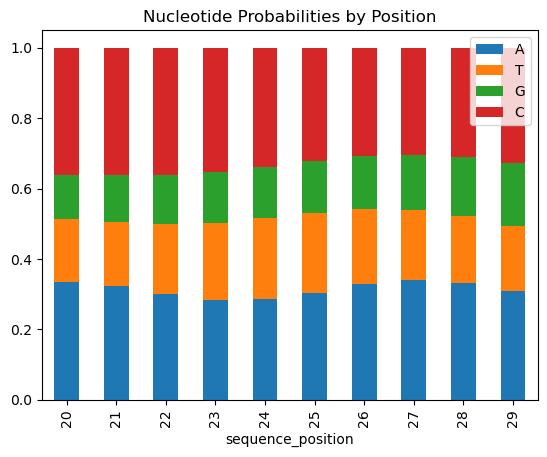

In [132]:
prob_df.plot(x='sequence_position', kind='bar', stacked=True,
        title='Nucleotide Probabilities by Position')
plt.show()

In [133]:
prob_df

,A,T,G,C,sequence_position
0,0.333806,0.179797,0.125816,0.360581,20
1,0.324118,0.182482,0.131340,0.362059,21
2,0.301417,0.199514,0.138699,0.360370,22
3,0.284580,0.219090,0.144285,0.352044,23
4,0.285880,0.229270,0.147112,0.337737,24
5,0.304728,0.225531,0.148845,0.320897,25
6,0.328454,0.212723,0.151502,0.307321,26
7,0.340441,0.199123,0.157158,0.303278,27
8,0.332209,0.189469,0.167299,0.311022,28
9,0.310597,0.183221,0.180107,0.326074,29
